In [43]:
%pip install pandas
%pip install tensorflow
%pip install tqdm
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [44]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [45]:
image_path = 'flick8k\Images'

In [46]:

data = pd.read_csv("flick8k\captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [47]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"flick8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

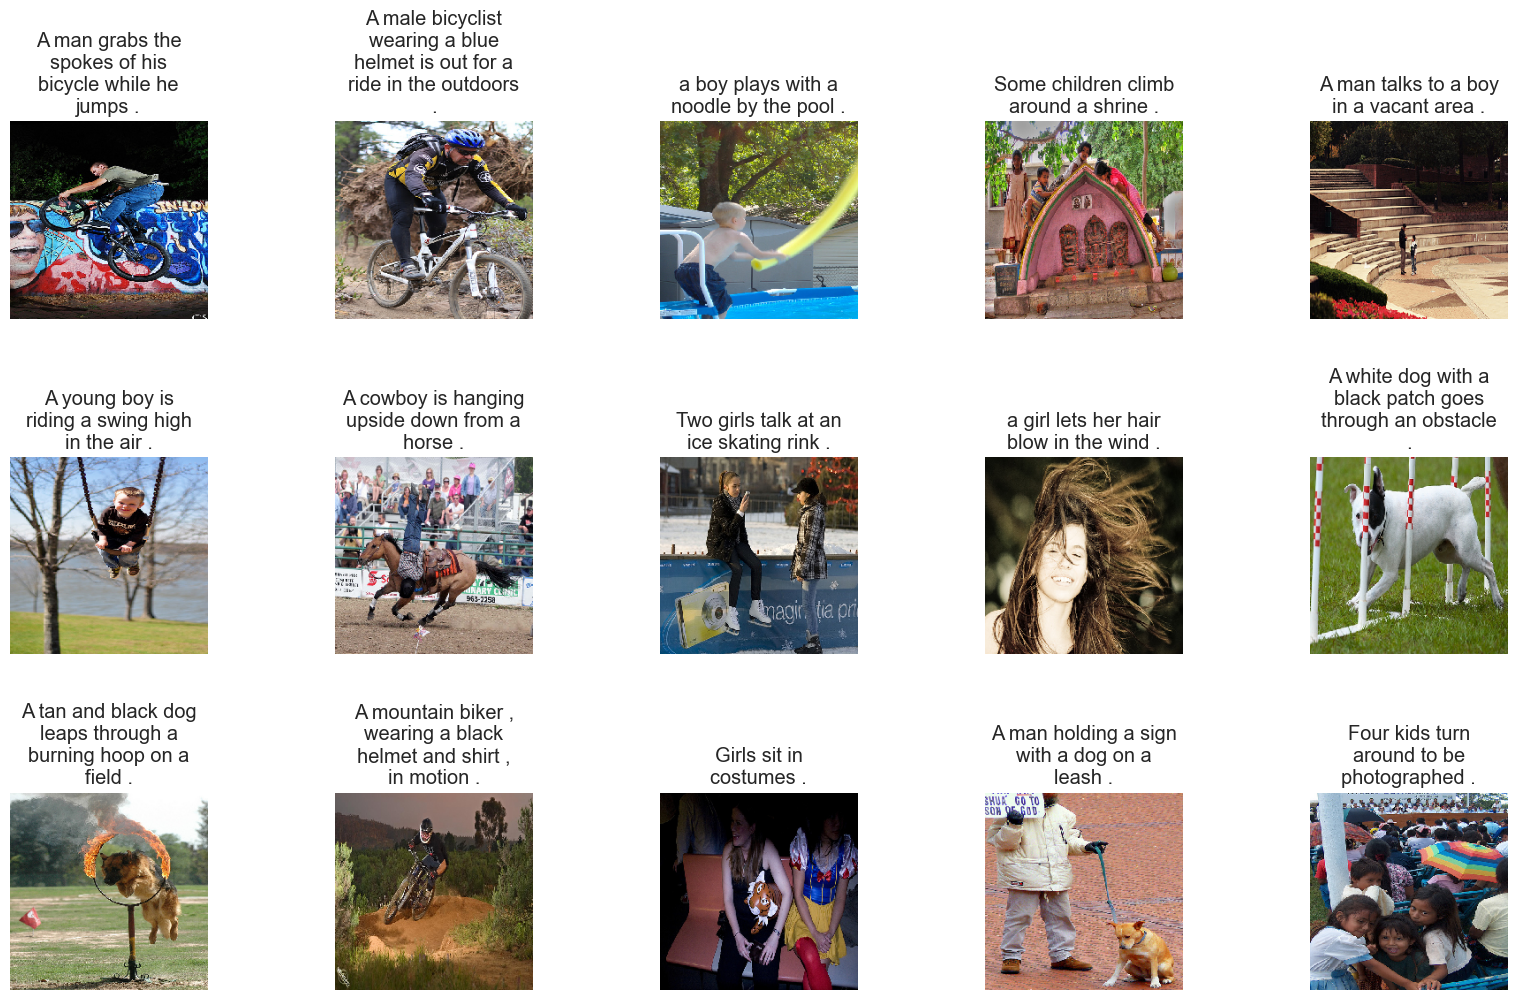

In [48]:
display_images(data.sample(15))

In [49]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [50]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [51]:
import pickle
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

# tokenizer.texts_to_sequences([captions[1]])[0]

# Save Tokenizer object as a pickle file
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [52]:
import pickle
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature
    
    # Save features dictionary as a pickle file
with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)

  3%|▎         | 219/8091 [01:36<55:08,  2.38it/s]  

: 

In [1]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

NameError: name 'Sequence' is not defined

In [3]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

NameError: name 'Input' is not defined

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
plot_model(caption_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
caption_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          491776      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                              

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [4]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

NameError: name 'ModelCheckpoint' is not defined

In [44]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - ETA: 0s - loss: 5.1582
Epoch 1: val_loss improved from inf to 4.31806, saving model to model.h5
537/537 [==============================] - 4257s 8s/step - loss: 5.1582 - val_loss: 4.3181 - lr: 0.0010
Epoch 2/50
537/537 [==============================] - ETA: 0s - loss: 4.2327
Epoch 2: val_loss improved from 4.31806 to 3.95378, saving model to model.h5
537/537 [==============================] - 1323s 2s/step - loss: 4.2327 - val_loss: 3.9538 - lr: 0.0010
Epoch 3/50
537/537 [==============================] - ETA: 0s - loss: 3.9547
Epoch 3: val_loss improved from 3.95378 to 3.79844, saving model to model.h5
537/537 [==============================] - 1363s 3s/step - loss: 3.9547 - val_loss: 3.7984 - lr: 0.0010
Epoch 4/50
537/537 [==============================] - ETA: 0s - loss: 3.7820
Epoch 4: val_loss improved from 3.79844 to 3.72132, saving model to model.h5
537/537 [==============================] - 1589s 3s/step - loss: 3.7820 - va

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

<Figure size 2000x800 with 0 Axes>

In [ ]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [ ]:
samples = test.sample(25)
samples.reset_index(drop=True,inplace=True)

In [ ]:
for index,record in samples.iterrows():
    
    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

NameError: name 'features' is not defined

In [65]:
display_images(samples)

NameError: name 'samples' is not defined

In [51]:
print(model.summary())

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [25]:
%pip install keras


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
caption_model = load_model('venv/model.h5')

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to predict caption for a given image
def predict_caption(model, image, tokenizer, max_length, features):
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature, sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text += " " + word

        if word == 'endseq':
            break

    return in_text 

# Use the function to generate captions for new images
image_path = '3637013_c675de7705.jpg'  # Change this to the path of your image
caption = predict_caption(caption_model, image_path, tokenizer, max_length, features)
print("Generated Caption:", caption)


In [7]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pickle
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# Function to read and preprocess a single image
def preprocess_image(image_path, img_size=224):
    img = load_img(image_path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Load the saved model
caption_model = tf.keras.models.load_model('models/model.h5')

# Define the features for the new image
new_image_path = 'static\OI.jpg'  # Change to the path of your image
new_image_features = fe.predict(preprocess_image(new_image_path))

# Function to predict caption for a given image
def predict_caption(model, features, tokenizer, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        y_pred = model.predict([features, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = idx_to_word(y_pred, tokenizer)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text

# Generate caption for the new image
generated_caption = predict_caption(caption_model, new_image_features, tokenizer, max_length)
print("Generated Caption:", generated_caption)


NameError: name 'DenseNet201' is not defined

In [30]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Function to convert index to word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to generate caption for a given image
def predict_caption(model, image_path, tokenizer, max_length, features):
    feature = features[image_path]
    # Remove the extra dimension
    feature = np.squeeze(feature, axis=0)
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Ensure sequence length matches max_length
        sequence = pad_sequences([sequence], maxlen=max_length)
        y_pred = model.predict([np.expand_dims(feature, axis=0), sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = idx_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

# Function to generate caption for a given image
def generate_caption(image_path, model_path, tokenizer_path, features_path, max_length):
    # Load the caption generation model
    caption_model = load_model(model_path)
    # Load the tokenizer
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)
    # Load the features
    with open(features_path, 'rb') as handle:
        features = pickle.load(handle)
    # Generate caption
    caption = predict_caption(caption_model, image_path, tokenizer, max_length, features)
    return caption

# Provide the paths and other necessary parameters
image_path = "3637013_c675de7705.jpg"  # Provide the path to your image
model_path = "models/model.h5"  # Provide the path to your model
tokenizer_path = "models/tokenizer.pkl"  # Provide the path to your tokenizer
features_path = "models/features.pkl"  # Provide the path to your features
max_length = 34  # Set the maximum length for caption

# Generate caption
caption = generate_caption(image_path, model_path, tokenizer_path, features_path, max_length)
print("Generated Caption:", caption)


Generated Caption: startseq two people are walking through the water endseq


In [42]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Function to convert index to word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to generate caption for a given image
def predict_caption(model, image_path, tokenizer, max_length, features):
    feature = features[image_path]
    # Remove the extra dimension
    feature = np.squeeze(feature, axis=0)
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Ensure sequence length matches max_length
        sequence = pad_sequences([sequence], maxlen=max_length)
        y_pred = model.predict([np.expand_dims(feature, axis=0), sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = idx_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

# Function to generate caption for a given image
def generate_caption(image_path, model_path, tokenizer_path, features_path, max_length):
    # Load the caption generation model
    caption_model = load_model(model_path)
    # Load the tokenizer
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)
    # Load the features
    with open(features_path, 'rb') as handle:
        features = pickle.load(handle)
    # Generate caption
    caption = predict_caption(caption_model, image_path, tokenizer, max_length, features)
    return caption

# Provide the paths and other necessary parameters
image_path = "1000268201_693b08cb0e.jpg"  # Provide the path to your image
model_path = "models/model.h5"  # Provide the path to your model
tokenizer_path = "models/tokenizer.pkl"  # Provide the path to your tokenizer
features_path = "models/features.pkl"  # Provide the path to your features
max_length = 34  # Set the maximum length for caption

# Generate caption
caption = generate_caption(image_path, model_path, tokenizer_path, features_path, max_length)
print("Generated Caption:", caption)


Generated Caption: startseq two children sit on bench endseq


In [10]:
%pip install nltk


     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     ---------------------------------------- 42.0/42.0 kB 1.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.2/1.5 MB 7.6 MB/s eta 0:00:01
   --------- ------------------------------ 0.4/1.5 MB 4.5 MB/s eta 0:00:01
   -------------- ------------------------- 0.6/1.5 MB 4.3 MB/s eta 0:00:01
   --------------------- ------------------ 0.8/1.5 MB 4.8 MB/s eta 0:00:01
   ----------------------------- ---------- 1.1/1.5 MB 5.0 MB/s eta 0:00:01
   ------------------------------------ --- 1.4/1.5 MB 4.9 MB/s eta 0:00:01
   ---------------------------------------  1.5/1.5 MB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 4.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/268.9 kB ? eta -:--:--
   ---------------------------------------  266.2/268.9 kB 8.3 MB/s eta 0:00:01
   -----------------

In [40]:
from nltk.translate.bleu_score import corpus_bleu

# Function to load captions from a file
def load_captions(file_path):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    captions = [caption.strip() for caption in captions]
    return captions

# Function to calculate BLEU score for all images
def calculate_bleu_score(reference_captions, generated_captions):
    bleu_scores = []
    for ref, gen in zip(reference_captions, generated_captions):
        bleu_score = corpus_bleu([[ref]], [gen])
        bleu_scores.append(bleu_score)
    return bleu_scores

# Path to the file containing reference captions
reference_file = "flick8k\captions.txt"
# Path to the file containing generated captions
generated_file = "generated_caption.txt"

# Load reference captions
reference_captions = load_captions(reference_file)
# Load generated captions
generated_captions = load_captions(generated_file)

# Calculate BLEU score for all images
bleu_scores = calculate_bleu_score(reference_captions, generated_captions)

# Calculate average BLEU score
average_bleu_score = sum(bleu_scores) / len(bleu_scores)

print("Average BLEU Score:", average_bleu_score)


Average BLEU Score: 3.593214167553618e-155
